# ============================================================
# 🌿 CSE 475 - Assignment: Weeds Object Detection (SSL)
# 📘 Soft Teacher Notebook — **Teacher–Student Semi-Supervised Training**
# ============================================================

### 👥 Group: 02
1. **Osama Bin Qashem** (2022-2-60-058)  
2. **Saif Khan** (2022-2-60-063)  
3. **Mahmudul Hasan Hamim** (2022-2-60-079)  
4. **Nusrat Jahan Oishi** (2022-2-60-033)

---

## 🏫 Institution
**East West University**  
Department of Computer Science and Engineering  

Course Code: **CSE 475** | Section: **03**  
Instructor: **Dr. Md. Rifat Ahmmad Rashid**

---

## 🎯 What this notebook does (Soft Teacher style)
This notebook follows a **Teacher → Pseudo-Label → Student** semi-supervised pipeline:

✅ **Step A — Labeled/Unlabeled Split (Train only)**  
- Use a fixed ratio (e.g., 20% labeled, 80% unlabeled)  
- Keep validation/test fully labeled for fair evaluation

✅ **Step B — Train Teacher (Supervised Warm-Up)**  
- Train on labeled subset only  
- The teacher learns clean, reliable patterns first

✅ **Step C — Generate Pseudo Labels (Teacher → Unlabeled)**  
- Run inference on unlabeled images  
- Keep only high-confidence boxes (`PSEUDO_CONF`)  
- Save them in **YOLO label format**

✅ **Step D — Train Student (Labeled + Pseudo-Labeled)**  
- Student trains on a mixed set:
  - **Ground Truth** labels for labeled images
  - **Pseudo Labels** for unlabeled images

✅ **Step E — Explainability (XAI) for SSL models** 🧠✨  
- **ScoreCAM** (gradient-free)
- **EigenCAM** (PCA-based)

### 📌 Required Plot Layout (Same as your YOLO notebooks)
**Columns:** Original | ScoreCAM | EigenCAM | Prediction  
**Rows:** Teacher, Student (actual names shown vertically)

---

## ⚠️ Important Note (Honest + Practical)
“Soft Teacher” in research typically includes **EMA (Exponential Moving Average) teacher updates** + consistency learning.  
Here we implement a **clean, report-friendly Soft-Teacher-style workflow** using Ultralytics YOLO:

- Teacher = supervised warm-up model  
- Student = trained using teacher pseudo-labels  

This matches the core idea: **use a teacher to leverage unlabeled data**.

# 0) Setup ⚙️

In [1]:
# ============================================================
# Install dependencies
# ============================================================
!pip install -q ultralytics --no-deps
!pip install -q ttach
!pip install -q tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.2 MB/s eta 0:00:00


In [2]:
# ============================================================
# Imports + global config
# ============================================================
import os
import random
import shutil
from pathlib import Path

import cv2
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from tqdm.auto import tqdm
from ultralytics import YOLO

plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["axes.grid"] = False

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# ------------------------------------------------------------
# Dataset paths (Kaggle)
# ------------------------------------------------------------
DATA_ROOT = Path("/kaggle/input/weeds-dataset")
RAW_DATA_YAML = DATA_ROOT / "data.yaml"
WORK_YAML_FULL = Path("/kaggle/working/weeds_full.yaml")

# ------------------------------------------------------------
# Soft Teacher / SSL settings
# ------------------------------------------------------------
LABELED_RATIO = 0.20        # 20% labeled, 80% unlabeled (train only)
SSL_WORKDIR = Path("/kaggle/working/soft_teacher_ssl")
SSL_WORKDIR.mkdir(parents=True, exist_ok=True)

# Models (use YOLOv12n as a strong base; you can swap to v10/v11 if needed)
TEACHER_MODEL_ID = "yolo12n.pt"
STUDENT_MODEL_ID = "yolo12n.pt"

# Train hyperparams
EPOCHS_TEACHER = 80
EPOCHS_STUDENT = 100
BATCH_SIZE = 16
IMAGE_SIZE = 640
PATIENCE = 15
DEVICE = 0  # set "cpu" if needed

# Pseudo label filtering
PSEUDO_CONF = 0.40
PSEUDO_IOU = 0.70

print("DATA_ROOT:", DATA_ROOT)
print("RAW_DATA_YAML:", RAW_DATA_YAML)
print("SSL_WORKDIR:", SSL_WORKDIR)
print("LABELED_RATIO:", LABELED_RATIO)
print("TEACHER_MODEL:", TEACHER_MODEL_ID)
print("STUDENT_MODEL:", STUDENT_MODEL_ID)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
DATA_ROOT: /kaggle/input/weeds-dataset
RAW_DATA_YAML: /kaggle/input/weeds-dataset/data.yaml
SSL_WORKDIR: /kaggle/working/soft_teacher_ssl
LABELED_RATIO: 0.2
TEACHER_MODEL: yolo12n.pt
STUDENT_MODEL: yolo12n.pt


# 1) Dataset Setup 📦 (Full YAML + SSL Split)

### ✅ Goal
Build:
- **Full dataset YAML** (train/val/test as provided)
- A deterministic **train-only SSL split**:
  - `train_labeled` → has GT labels ✅  
  - `train_unlabeled` → images only (no GT used) 🕵️  

### 🧠 Why split only the train set?
Validation/test must remain fully labeled so metrics are fair and comparable.

In [3]:
# ============================================================
# Build a robust "full" weeds.yaml (points to Kaggle dataset)
# ============================================================
def make_full_yaml(data_root: Path, raw_yaml: Path, out_yaml: Path):
    names = ["Weeds"]
    nc = 1

    if raw_yaml.exists():
        try:
            raw = yaml.safe_load(raw_yaml.read_text())
            if isinstance(raw, dict):
                if "names" in raw and raw["names"]:
                    names = raw["names"] if isinstance(raw["names"], list) else list(raw["names"])
                if "nc" in raw:
                    nc = int(raw["nc"])
        except Exception as e:
            print("[WARN] Could not parse data.yaml:", e)

    data_yaml = {
        "train": str((data_root / "train" / "images").resolve()).replace("\\", "/"),
        "val":   str((data_root / "valid" / "images").resolve()).replace("\\", "/"),
        "test":  str((data_root / "test" / "images").resolve()).replace("\\", "/"),
        "nc": nc,
        "names": names,
    }
    out_yaml.write_text(yaml.dump(data_yaml, sort_keys=False))
    return data_yaml

cfg_full = make_full_yaml(DATA_ROOT, RAW_DATA_YAML, WORK_YAML_FULL)
CLASS_NAMES = cfg_full["names"]
NC = cfg_full["nc"]

print("Full YAML saved:", WORK_YAML_FULL)
print(yaml.dump(cfg_full, sort_keys=False))

Full YAML saved: /kaggle/working/weeds_full.yaml
train: /kaggle/input/weeds-dataset/train/images
val: /kaggle/input/weeds-dataset/valid/images
test: /kaggle/input/weeds-dataset/test/images
nc: 1
names:
- Weeds



In [4]:
# ============================================================
# Helpers
# ============================================================
IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".webp")

def list_images(img_dir: Path):
    files = []
    for ext in IMG_EXTS:
        files.extend(img_dir.glob(f"*{ext}"))
    return sorted(files)

def label_path_from_image(img_path: Path):
    return img_path.parent.parent / "labels" / f"{img_path.stem}.txt"

def safe_link_or_copy(src: Path, dst: Path):
    """
    Prefer symlink to avoid large copies.
    Falls back to copy if symlink fails.
    """
    dst.parent.mkdir(parents=True, exist_ok=True)
    if dst.exists():
        return
    try:
        os.symlink(src, dst)
    except Exception:
        shutil.copy2(src, dst)

In [5]:
# ============================================================
# Create SSL split (train only): labeled + unlabeled
# Output structure:
#   soft_teacher_ssl/
#     labeled/images + labeled/labels
#     combined/images + combined/labels   (GT + pseudo labels)
# ============================================================
train_img_dir = Path(cfg_full["train"])
train_imgs = list_images(train_img_dir)
assert len(train_imgs) > 0, "No training images found."

random.Random(SEED).shuffle(train_imgs)
n_labeled = int(round(LABELED_RATIO * len(train_imgs)))
labeled_imgs = train_imgs[:n_labeled]
unlabeled_imgs = train_imgs[n_labeled:]

print(f"Train images total: {len(train_imgs)}")
print(f"Labeled: {len(labeled_imgs)} ({LABELED_RATIO*100:.0f}%)")
print(f"Unlabeled: {len(unlabeled_imgs)} ({(1-LABELED_RATIO)*100:.0f}%)")

# Prepare directories
LABELED_DIR = SSL_WORKDIR / "train_labeled"
COMBINED_DIR = SSL_WORKDIR / "train_combined"
PSEUDO_DIR = SSL_WORKDIR / "pseudo_labels"

for d in [
    LABELED_DIR / "images", LABELED_DIR / "labels",
    COMBINED_DIR / "images", COMBINED_DIR / "labels",
    PSEUDO_DIR / "labels"
]:
    d.mkdir(parents=True, exist_ok=True)

# Link/copy labeled set into train_labeled and train_combined (GT labels)
for img_path in tqdm(labeled_imgs, desc="Preparing labeled subset"):
    lbl_path = label_path_from_image(img_path)

    # labeled subset
    safe_link_or_copy(img_path, LABELED_DIR / "images" / img_path.name)
    if lbl_path.exists():
        safe_link_or_copy(lbl_path, LABELED_DIR / "labels" / lbl_path.name)
    else:
        # create empty label file if missing (keeps format consistent)
        (LABELED_DIR / "labels" / lbl_path.name).write_text("")

    # combined set (GT)
    safe_link_or_copy(img_path, COMBINED_DIR / "images" / img_path.name)
    if lbl_path.exists():
        safe_link_or_copy(lbl_path, COMBINED_DIR / "labels" / lbl_path.name)
    else:
        (COMBINED_DIR / "labels" / lbl_path.name).write_text("")

# Link/copy unlabeled images into train_combined (labels will be pseudo later)
for img_path in tqdm(unlabeled_imgs, desc="Preparing unlabeled images for combined set"):
    safe_link_or_copy(img_path, COMBINED_DIR / "images" / img_path.name)
    # NOTE: label file will be created after pseudo-labeling step

print("\n✅ SSL folders ready:")
print(" - LABELED_DIR:", LABELED_DIR)
print(" - COMBINED_DIR:", COMBINED_DIR)
print(" - PSEUDO_DIR:", PSEUDO_DIR)

Train images total: 2942
Labeled: 588 (20%)
Unlabeled: 2354 (80%)


Preparing labeled subset:   0%|          | 0/588 [00:00<?, ?it/s]

Preparing unlabeled images for combined set:   0%|          | 0/2354 [00:00<?, ?it/s]


✅ SSL folders ready:
 - LABELED_DIR: /kaggle/working/soft_teacher_ssl/train_labeled
 - COMBINED_DIR: /kaggle/working/soft_teacher_ssl/train_combined
 - PSEUDO_DIR: /kaggle/working/soft_teacher_ssl/pseudo_labels


In [6]:
# ============================================================
# Create YOLO YAMLs for Teacher and Student
# Teacher trains on LABELED only
# Student trains on COMBINED (GT + Pseudo)
# ============================================================
WORK_YAML_TEACHER = SSL_WORKDIR / "weeds_teacher.yaml"
WORK_YAML_STUDENT = SSL_WORKDIR / "weeds_student.yaml"

teacher_yaml = {
    "train": str((LABELED_DIR / "images").resolve()).replace("\\", "/"),
    "val":   str((DATA_ROOT / "valid" / "images").resolve()).replace("\\", "/"),
    "test":  str((DATA_ROOT / "test" / "images").resolve()).replace("\\", "/"),
    "nc": NC,
    "names": CLASS_NAMES,
}
student_yaml = {
    "train": str((COMBINED_DIR / "images").resolve()).replace("\\", "/"),
    "val":   str((DATA_ROOT / "valid" / "images").resolve()).replace("\\", "/"),
    "test":  str((DATA_ROOT / "test" / "images").resolve()).replace("\\", "/"),
    "nc": NC,
    "names": CLASS_NAMES,
}

WORK_YAML_TEACHER.write_text(yaml.dump(teacher_yaml, sort_keys=False))
WORK_YAML_STUDENT.write_text(yaml.dump(student_yaml, sort_keys=False))

print("Teacher YAML:", WORK_YAML_TEACHER)
print("Student YAML:", WORK_YAML_STUDENT)

Teacher YAML: /kaggle/working/soft_teacher_ssl/weeds_teacher.yaml
Student YAML: /kaggle/working/soft_teacher_ssl/weeds_student.yaml


## 👀 Quick Visual Check (Labeled Subset)
We show a few labeled training images with GT boxes.
This ensures the subset pipeline didn't break paths or labels.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


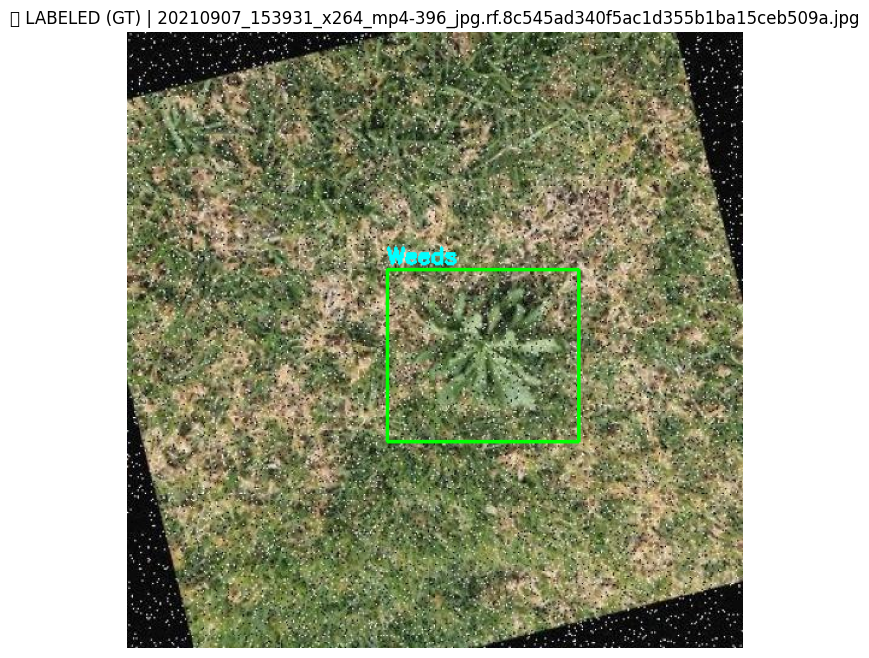

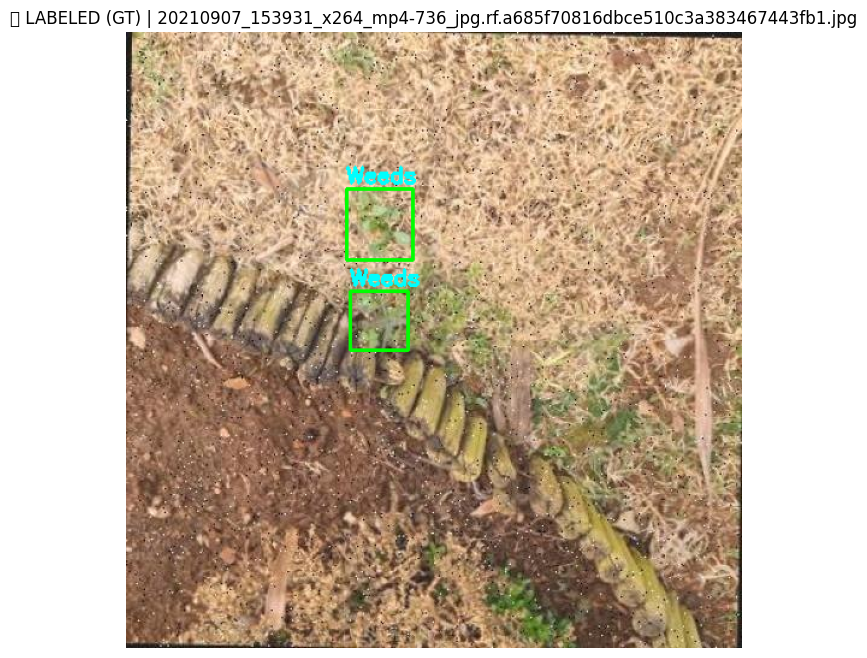

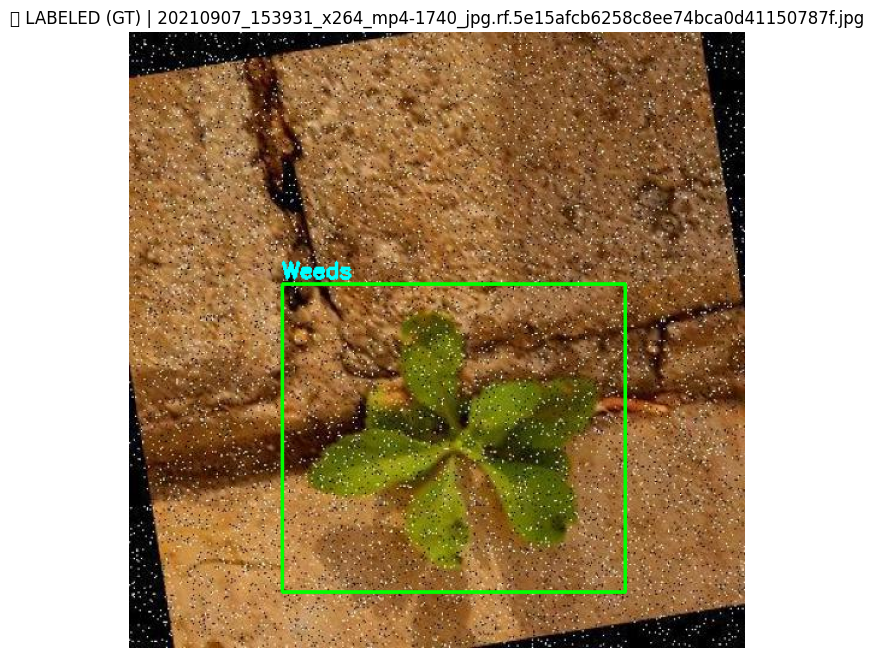

In [7]:
def read_yolo_labels(txt_path: Path):
    rows = []
    if not txt_path.exists():
        return rows
    for line in txt_path.read_text().strip().splitlines():
        parts = line.strip().split()
        if len(parts) < 5:
            continue
        cls, x, y, w, h = parts[:5]
        rows.append((int(float(cls)), float(x), float(y), float(w), float(h)))
    return rows

def visualize_from_folder(img_dir: Path, n: int = 3, title_prefix: str = "LABELED"):
    img_files = []
    for ext in IMG_EXTS:
        img_files.extend(img_dir.glob(f"*{ext}"))
    if not img_files:
        print("No images found in:", img_dir)
        return
    random.shuffle(img_files)
    img_files = img_files[:n]

    label_dir = img_dir.parent / "labels"

    for p in img_files:
        bgr = cv2.imread(str(p))
        if bgr is None:
            continue
        h, w = bgr.shape[:2]
        lbl = label_dir / f"{p.stem}.txt"

        if lbl.exists():
            for cls, x, y, bw, bh in read_yolo_labels(lbl):
                x1 = int((x - bw/2) * w); y1 = int((y - bh/2) * h)
                x2 = int((x + bw/2) * w); y2 = int((y + bh/2) * h)
                cv2.rectangle(bgr, (x1,y1), (x2,y2), (0,255,0), 2)
                name = CLASS_NAMES[cls] if cls < len(CLASS_NAMES) else str(cls)
                cv2.putText(bgr, name, (x1, max(0,y1-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,0), 2)

        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        plt.figure()
        plt.imshow(rgb); plt.axis("off")
        plt.title(f"{title_prefix} | {p.name}")
        plt.show()

visualize_from_folder(LABELED_DIR / "images", n=3, title_prefix="✅ LABELED (GT)")

# 2) Train Teacher 🧑‍🏫 (Supervised Warm-Up)

### ✅ Why warm-up?
The teacher must be trained on **clean GT labels** before it can produce meaningful pseudo labels.

**Output:**  
- `best.pt` teacher weights

In [8]:
PROJECT_TEACHER = "/kaggle/working/soft_teacher_teacher_train"
RUN_TEACHER = "teacher_yolo12n_labeled"
BEST_TEACHER = f"{PROJECT_TEACHER}/{RUN_TEACHER}/weights/best.pt"

if Path(BEST_TEACHER).exists():
    print("[SKIP] Found existing Teacher weights:", BEST_TEACHER)
else:
    teacher = YOLO(TEACHER_MODEL_ID)
    teacher.train(
        data=str(WORK_YAML_TEACHER),
        epochs=EPOCHS_TEACHER,
        imgsz=IMAGE_SIZE,
        batch=BATCH_SIZE,
        project=PROJECT_TEACHER,
        name=RUN_TEACHER,
        device=DEVICE,
        patience=PATIENCE,
        workers=2,
        exist_ok=True,
    )
    print("✅ Teacher training done.")
    print("Teacher best weights:", BEST_TEACHER)

Ultralytics 8.3.240 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/soft_teacher_ssl/weeds_teacher.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=80, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=teacher_yolo12n_labeled, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, 

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        630       1694      0.919      0.847      0.912      0.632
Speed: 0.2ms preprocess, 2.9ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to /kaggle/working/soft_teacher_teacher_train/teacher_yolo12n_labeled
✅ Teacher training done.
Teacher best weights: /kaggle/working/soft_teacher_teacher_train/teacher_yolo12n_labeled/weights/best.pt


# 3) Generate Pseudo Labels 🧾✨ (Teacher → Unlabeled)

### ✅ What happens here?
For each unlabeled image:
- Teacher predicts boxes  
- We keep predictions above `PSEUDO_CONF`  
- Save them as YOLO `.txt` labels

### 🔥 Why confidence filtering matters?
Low-confidence pseudo labels can inject noise and hurt the student model.

In [9]:
# ============================================================
# Convert teacher predictions -> YOLO label files
# ============================================================
def save_pseudo_labels_for_image(result, img_bgr, out_txt: Path, conf_thr: float = 0.4):
    """
    result: ultralytics Results for one image
    img_bgr: original BGR image (for width/height)
    out_txt: where to save YOLO labels
    """
    h, w = img_bgr.shape[:2]
    lines = []

    if result.boxes is not None and len(result.boxes) > 0:
        xyxy = result.boxes.xyxy.detach().cpu().numpy()
        cls = result.boxes.cls.detach().cpu().numpy().astype(int)
        conf = result.boxes.conf.detach().cpu().numpy()

        for (x1, y1, x2, y2), c, s in zip(xyxy, cls, conf):
            if float(s) < conf_thr:
                continue
            # YOLO normalized
            xc = ((x1 + x2) / 2) / w
            yc = ((y1 + y2) / 2) / h
            bw = (x2 - x1) / w
            bh = (y2 - y1) / h
            # clip for safety
            xc = float(np.clip(xc, 0, 1))
            yc = float(np.clip(yc, 0, 1))
            bw = float(np.clip(bw, 0, 1))
            bh = float(np.clip(bh, 0, 1))

            lines.append(f"{int(c)} {xc:.6f} {yc:.6f} {bw:.6f} {bh:.6f}")

    out_txt.parent.mkdir(parents=True, exist_ok=True)
    out_txt.write_text("\n".join(lines) + ("\n" if lines else ""))

# Load teacher weights
if not Path(BEST_TEACHER).exists():
    raise FileNotFoundError("Teacher weights not found. Run Teacher training first.")

teacher_infer = YOLO(str(BEST_TEACHER))

# Generate pseudo labels for unlabeled images
pseudo_stats = []
unlabeled_img_paths = unlabeled_imgs  # from split step above

for img_path in tqdm(unlabeled_img_paths, desc="Generating pseudo labels"):
    bgr = cv2.imread(str(img_path))
    if bgr is None:
        continue

    # inference
    res = teacher_infer.predict(
        bgr,
        imgsz=IMAGE_SIZE,
        conf=PSEUDO_CONF,   # pre-filter at predictor
        iou=PSEUDO_IOU,
        device=DEVICE,
        verbose=False
    )[0]

    out_txt = PSEUDO_DIR / "labels" / f"{img_path.stem}.txt"
    save_pseudo_labels_for_image(res, bgr, out_txt, conf_thr=PSEUDO_CONF)

    # Copy pseudo labels into the COMBINED labels folder
    combined_lbl = COMBINED_DIR / "labels" / f"{img_path.stem}.txt"
    safe_link_or_copy(out_txt, combined_lbl)

    # stats
    n_boxes = int(len(res.boxes)) if res.boxes is not None else 0
    pseudo_stats.append({"image": img_path.name, "pseudo_boxes_raw": n_boxes})

df_pseudo = pd.DataFrame(pseudo_stats)
display(df_pseudo.head())

print("\n✅ Pseudo-labeling done.")
print("Pseudo labels stored at:", PSEUDO_DIR / "labels")
print("Combined labels updated at:", COMBINED_DIR / "labels")

Generating pseudo labels:   0%|          | 0/2354 [00:00<?, ?it/s]

image  pseudo_boxes_raw
0  20210907_153931_x264_mp4-904_jpg.rf.16695f3abc...                 1
1  20210907_153931_x264_mp4-520_jpg.rf.cc4b849df8...                 1
2  20210907_153931_x264_mp4-1795_jpg.rf.b64824ab0...                 1
3  20210907_153931_x264_mp4-1570_jpg.rf.4f2361e83...                 4
4  20210907_153931_x264_mp4-232_jpg.rf.92f57445c9...                 4


✅ Pseudo-labeling done.
Pseudo labels stored at: /kaggle/working/soft_teacher_ssl/pseudo_labels/labels
Combined labels updated at: /kaggle/working/soft_teacher_ssl/train_combined/labels


## 📊 Pseudo Label Health Check
We summarize how many pseudo boxes were generated per image.

🔎 If pseudo boxes are mostly zero:
- Teacher might be under-trained  
- `PSEUDO_CONF` might be too high  
- Dataset might be hard / tiny weeds

count    2354.000000
mean        2.550977
std         2.464226
min         0.000000
25%         1.000000
50%         1.500000
75%         3.000000
max        17.000000


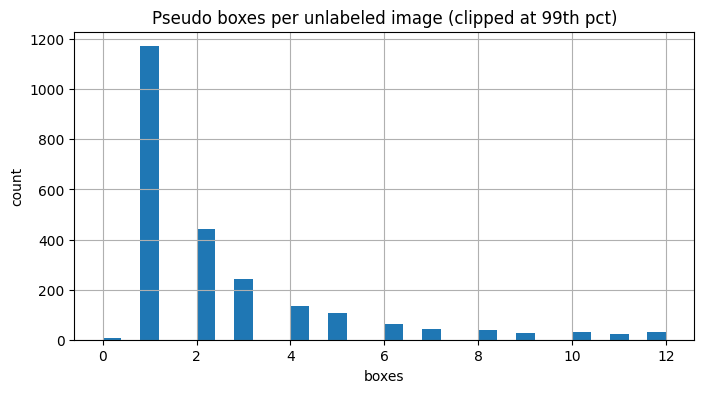

In [10]:
if len(df_pseudo) > 0:
    print(df_pseudo["pseudo_boxes_raw"].describe().to_string())
    plt.figure(figsize=(8,4))
    df_pseudo["pseudo_boxes_raw"].clip(0, df_pseudo["pseudo_boxes_raw"].quantile(0.99)).hist(bins=30)
    plt.title("Pseudo boxes per unlabeled image (clipped at 99th pct)")
    plt.xlabel("boxes"); plt.ylabel("count")
    plt.show()
else:
    print("[WARN] No pseudo stats collected.")

# 4) Train Student 🎓 (Labeled + Pseudo-Labeled)

### ✅ What the student learns from
- **GT labels** for labeled images ✅  
- **Pseudo labels** for unlabeled images 🧾  

This is where unlabeled data becomes useful.

In [11]:
PROJECT_STUDENT = "/kaggle/working/soft_teacher_student_train"
RUN_STUDENT = "student_yolo12n_combined"
BEST_STUDENT = f"{PROJECT_STUDENT}/{RUN_STUDENT}/weights/best.pt"

if Path(BEST_STUDENT).exists():
    print("[SKIP] Found existing Student weights:", BEST_STUDENT)
else:
    # Starting from teacher weights often stabilizes training
    student = YOLO(str(BEST_TEACHER)) if Path(BEST_TEACHER).exists() else YOLO(STUDENT_MODEL_ID)

    student.train(
        data=str(WORK_YAML_STUDENT),
        epochs=EPOCHS_STUDENT,
        imgsz=IMAGE_SIZE,
        batch=BATCH_SIZE,
        project=PROJECT_STUDENT,
        name=RUN_STUDENT,
        device=DEVICE,
        patience=PATIENCE,
        workers=2,
        exist_ok=True,
    )
    print("✅ Student training done.")
    print("Student best weights:", BEST_STUDENT)

Ultralytics 8.3.240 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/soft_teacher_ssl/weeds_student.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/kaggle/working/soft_teacher_teacher_train/teacher_yolo12n_labeled/weights/best.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=student_yolo12n_combined, nbs=64, 

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        630       1694      0.925      0.873      0.929      0.659
Speed: 0.2ms preprocess, 2.9ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to /kaggle/working/soft_teacher_student_train/student_yolo12n_combined
✅ Student training done.
Student best weights: /kaggle/working/soft_teacher_student_train/student_yolo12n_combined/weights/best.pt


# 5) Evaluation 📈 (Teacher vs Student on Test Split)

We compare performance on the **same test set**:
- mAP@0.5  
- mAP@0.5:0.95  
- Precision / Recall  
- F1 Score  

✅ This is the cleanest way to show SSL benefit.

In [12]:
from pathlib import Path

def evaluate_one_model(model_name: str, weight_path: str, data_yaml: Path):
    weight_path = Path(weight_path)
    if not weight_path.exists():
        raise FileNotFoundError(f"Weights not found: {weight_path}")

    model = YOLO(str(weight_path))
    test_results = model.val(data=str(data_yaml), split="test")

    box = test_results.box
    p = box.p
    r = box.r

    precision = float(p.mean()) if hasattr(p, "mean") else float(p)
    recall    = float(r.mean()) if hasattr(r, "mean") else float(r)
    map50     = float(box.map50)
    map5095   = float(box.map)

    f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0

    return {
        "Model": model_name,
        "mAP@0.5": map50,
        "mAP@0.5:0.95": map5095,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
    }

rows = []
if Path(BEST_TEACHER).exists():
    rows.append(evaluate_one_model("Teacher (Labeled Only)", BEST_TEACHER, WORK_YAML_STUDENT))
if Path(BEST_STUDENT).exists():
    rows.append(evaluate_one_model("Student (GT + Pseudo)", BEST_STUDENT, WORK_YAML_STUDENT))

df_eval = pd.DataFrame(rows)
display(df_eval)

out_eval_path = "/kaggle/working/soft_teacher_eval.csv"
df_eval.to_csv(out_eval_path, index=False)
print("Saved:", out_eval_path)

Ultralytics 8.3.240 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv12n summary (fused): 159 layers, 2,556,923 parameters, 0 gradients
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 13.5±2.1 MB/s, size: 77.9 KB)
val: Scanning /kaggle/input/weeds-dataset/test/labels... 631 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 631/631 271.9it/s 2.3s
WARNING ⚠️ val: Cache directory /kaggle/input/weeds-dataset/test is not writable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 40/40 6.3it/s 6.4s


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        631       1654      0.911      0.837       0.91      0.634
Speed: 1.2ms preprocess, 3.8ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /kaggle/working/runs/detect/val
Ultralytics 8.3.240 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv12n summary (fused): 159 layers, 2,556,923 parameters, 0 gradients
val: Fast image access ✅ (ping: 0.1±0.2 ms, read: 179.2±26.3 MB/s, size: 91.1 KB)
val: Scanning /kaggle/input/weeds-dataset/test/labels... 631 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 631/631 1.0Kit/s 0.6s
WARNING ⚠️ val: Cache directory /kaggle/input/weeds-dataset/test is not writable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 40/40 6.5it/s 6.1s


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        631       1654      0.928      0.868      0.933      0.666
Speed: 1.2ms preprocess, 3.9ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /kaggle/working/runs/detect/val2


Model   mAP@0.5  mAP@0.5:0.95  Precision    Recall  \
0  Teacher (Labeled Only)  0.910148      0.634480   0.910734  0.836759   
1   Student (GT + Pseudo)  0.932825      0.665995   0.927665  0.868411   

   F1 Score  
0  0.872181  
1  0.897061

Saved: /kaggle/working/soft_teacher_eval.csv


# 6) Training Curves 📉 (Teacher & Student)
We plot:
- Box loss  
- mAP@0.5  

This makes training behavior easy to explain in the report.

Looking for: /kaggle/working/soft_teacher_teacher_train/teacher_yolo12n_labeled/results.csv


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129489 (\N{ADULT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127979 (\N{SCHOOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


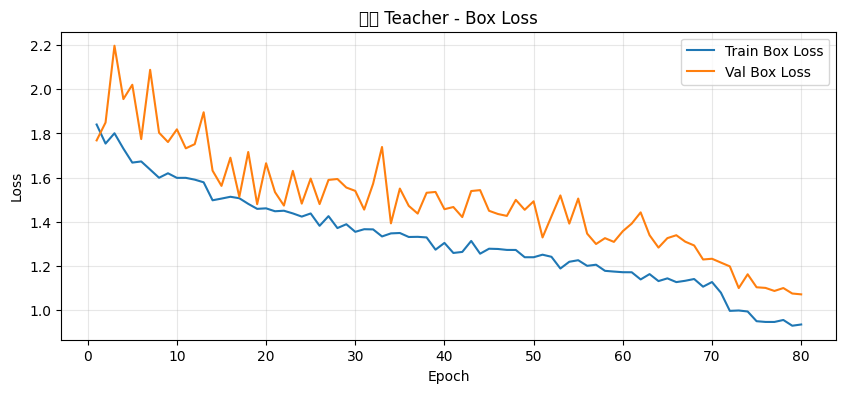

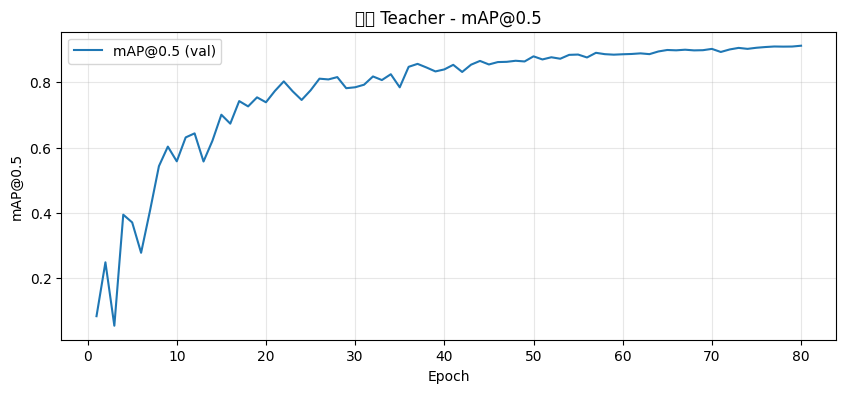

Looking for: /kaggle/working/soft_teacher_student_train/student_yolo12n_combined/results.csv


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127891 (\N{GRADUATION CAP}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


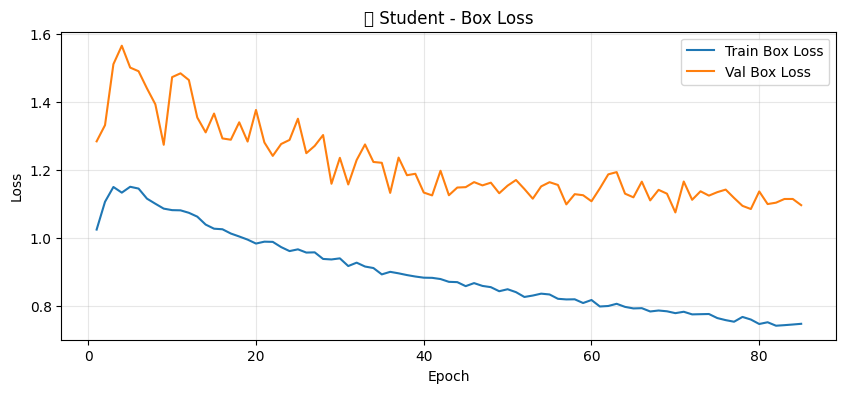

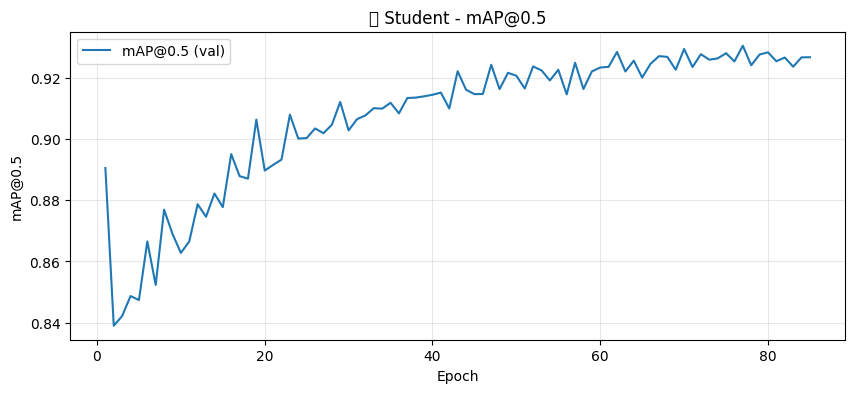

In [13]:
def plot_training_curves(project_dir: str, run_name: str, title_prefix: str):
    csv_path = Path(project_dir) / run_name / "results.csv"
    print("Looking for:", csv_path)

    if not csv_path.exists():
        print("[WARN] results.csv not found.")
        return

    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.strip()

    # Box loss
    plt.figure(figsize=(10, 4))
    if "train/box_loss" in df.columns:
        plt.plot(df["epoch"], df["train/box_loss"], label="Train Box Loss")
    if "val/box_loss" in df.columns:
        plt.plot(df["epoch"], df["val/box_loss"], label="Val Box Loss")
    plt.title(f"{title_prefix} - Box Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.grid(True, alpha=0.3); plt.legend()
    plt.show()

    # mAP50
    plt.figure(figsize=(10, 4))
    if "metrics/mAP50(B)" in df.columns:
        plt.plot(df["epoch"], df["metrics/mAP50(B)"], label="mAP@0.5 (val)")
        plt.title(f"{title_prefix} - mAP@0.5")
        plt.xlabel("Epoch"); plt.ylabel("mAP@0.5")
        plt.grid(True, alpha=0.3); plt.legend()
        plt.show()
    else:
        print("[WARN] metrics/mAP50(B) not available in results.csv.")

plot_training_curves(PROJECT_TEACHER, RUN_TEACHER, "🧑‍🏫 Teacher")
plot_training_curves(PROJECT_STUDENT, RUN_STUDENT, "🎓 Student")

# 7) Qualitative Inference 🖼️ (Teacher vs Student)
We visualize predictions on test images for an intuitive comparison.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129489 (\N{ADULT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127979 (\N{SCHOOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


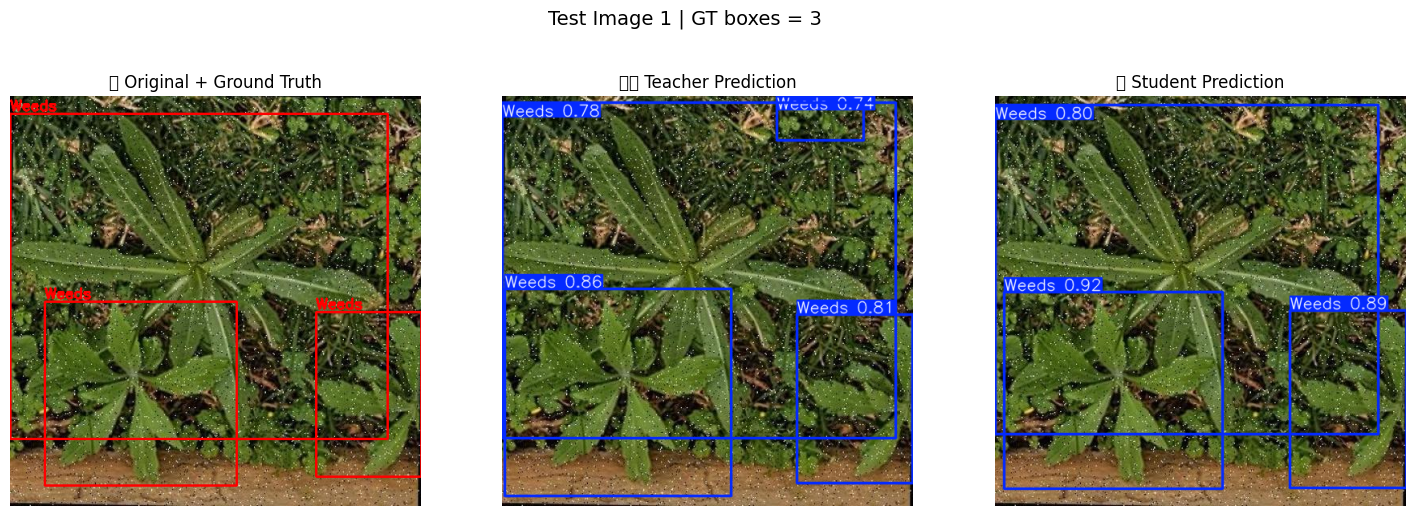

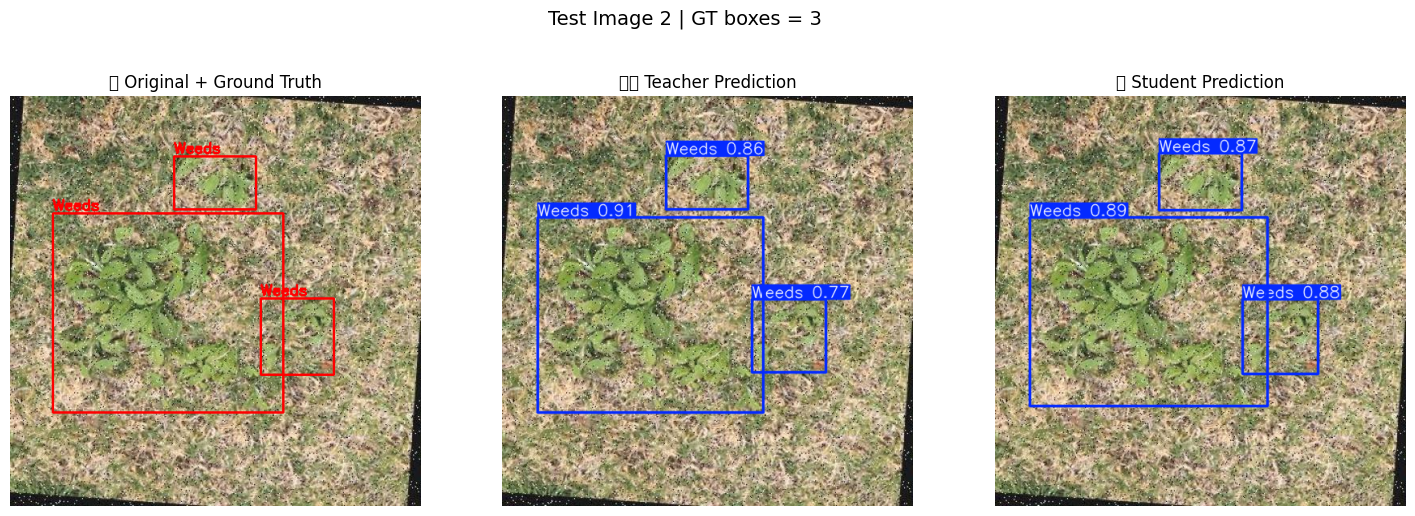

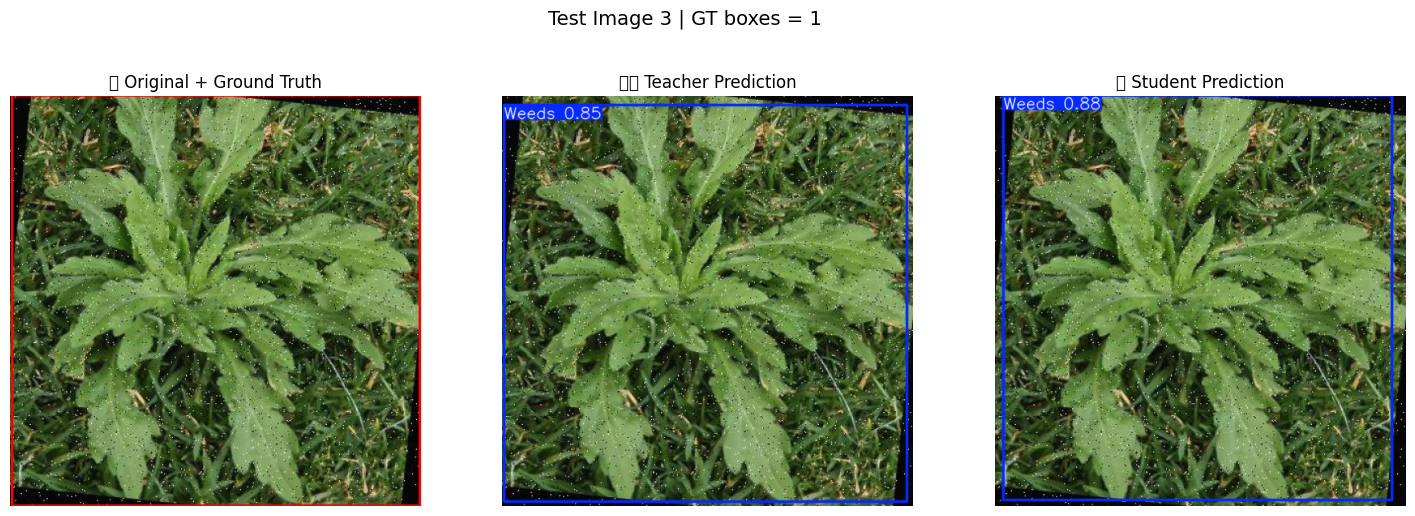

In [14]:
def draw_gt_on_rgb(rgb_img, label_path: Path, class_names):
    img = rgb_img.copy()
    h, w = img.shape[:2]
    if not label_path.exists():
        return img, 0

    gt_count = 0
    for cls, x, y, bw, bh in read_yolo_labels(label_path):
        x1 = int((x - bw/2) * w); y1 = int((y - bh/2) * h)
        x2 = int((x + bw/2) * w); y2 = int((y + bh/2) * h)
        cv2.rectangle(img, (x1,y1), (x2,y2), (255,0,0), 2)
        name = class_names[cls] if cls < len(class_names) else str(cls)
        cv2.putText(img, name, (x1, max(0,y1-4)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0), 2)
        gt_count += 1
    return img, gt_count

CONF_PRED = 0.25
IOU_PRED = 0.70

test_dir = Path(cfg_full["test"])
test_imgs = list_images(test_dir)
label_dir = test_dir.parent / "labels"
sample_paths = random.sample(test_imgs, k=min(3, len(test_imgs)))

teacher_vis = YOLO(str(BEST_TEACHER)) if Path(BEST_TEACHER).exists() else None
student_vis = YOLO(str(BEST_STUDENT)) if Path(BEST_STUDENT).exists() else None

for idx, img_path in enumerate(sample_paths, start=1):
    bgr = cv2.imread(str(img_path))
    if bgr is None:
        continue
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    gt_path = label_dir / f"{img_path.stem}.txt"
    gt_img, gt_count = draw_gt_on_rgb(rgb, gt_path, CLASS_NAMES)

    plt.figure(figsize=(18, 6))
    plt.suptitle(f"Test Image {idx} | GT boxes = {gt_count}", fontsize=14)

    # GT
    plt.subplot(1, 3, 1)
    plt.imshow(gt_img); plt.axis("off")
    plt.title("✅ Original + Ground Truth")

    # Teacher
    if teacher_vis is not None:
        rT = teacher_vis.predict(bgr, imgsz=IMAGE_SIZE, conf=CONF_PRED, iou=IOU_PRED, device=DEVICE, verbose=False)[0]
        t_rgb = cv2.cvtColor(rT.plot(), cv2.COLOR_BGR2RGB)
        plt.subplot(1, 3, 2)
        plt.imshow(t_rgb); plt.axis("off")
        plt.title("🧑‍🏫 Teacher Prediction")
    else:
        plt.subplot(1, 3, 2)
        plt.axis("off")
        plt.title("Teacher not available")

    # Student
    if student_vis is not None:
        rS = student_vis.predict(bgr, imgsz=IMAGE_SIZE, conf=CONF_PRED, iou=IOU_PRED, device=DEVICE, verbose=False)[0]
        s_rgb = cv2.cvtColor(rS.plot(), cv2.COLOR_BGR2RGB)
        plt.subplot(1, 3, 3)
        plt.imshow(s_rgb); plt.axis("off")
        plt.title("🎓 Student Prediction")
    else:
        plt.subplot(1, 3, 3)
        plt.axis("off")
        plt.title("Student not available")

    plt.show()

# 8) Explainability 🧠✨ (ScoreCAM + EigenCAM Grid)

### ✅ What you get
A clean report-ready grid:

**Columns:** Original | ScoreCAM | EigenCAM | Prediction  
**Rows:** Teacher, Student  

### ⚡ Runtime tip
ScoreCAM is expensive (many forward passes).  
Use `SCORECAM_CHANNELS = 12` for Kaggle speed. Increase to `24` for richer maps.

In [15]:
# ============================================================
# CAM utilities (ScoreCAM + EigenCAM) — same style as your YOLO notebooks
# ============================================================
def find_last_conv_layer(module: nn.Module) -> nn.Module:
    last = None
    for m in module.modules():
        if isinstance(m, nn.Conv2d):
            last = m
    if last is None:
        raise ValueError("No Conv2d layer found.")
    return last

def normalize01(x: np.ndarray, eps: float = 1e-6) -> np.ndarray:
    x = x.astype(np.float32)
    mn, mx = float(np.min(x)), float(np.max(x))
    if (mx - mn) < eps:
        return np.zeros_like(x, dtype=np.float32)
    return (x - mn) / (mx - mn + eps)

def overlay_heatmap(rgb_uint8: np.ndarray, heat01: np.ndarray, alpha: float = 0.45) -> np.ndarray:
    heat_u8 = np.uint8(np.clip(heat01, 0, 1) * 255)
    heat_bgr = cv2.applyColorMap(heat_u8, cv2.COLORMAP_JET)
    heat_rgb = cv2.cvtColor(heat_bgr, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

    base = rgb_uint8.astype(np.float32) / 255.0
    out = (1 - alpha) * base + alpha * heat_rgb
    return np.clip(out, 0, 1)

def eigencam_from_activations(acts_chw: np.ndarray) -> np.ndarray:
    C, H, W = acts_chw.shape
    A = acts_chw.reshape(C, -1).T  # (H*W, C)
    A = np.nan_to_num(A)

    _, _, Vt = np.linalg.svd(A, full_matrices=False)
    pc = Vt[0]
    cam = (A @ pc).reshape(H, W)
    cam = np.maximum(cam, 0)
    return normalize01(cam)

def detection_score_sum_conf(yolo: YOLO, img_bgr: np.ndarray, class_id: int = 0,
                             imgsz: int = 640, conf: float = 0.05, iou: float = 0.7, device=0) -> float:
    res = yolo.predict(img_bgr, imgsz=imgsz, conf=conf, iou=iou, device=device, verbose=False)[0]
    if res.boxes is None or len(res.boxes) == 0:
        return 0.0
    cls = res.boxes.cls.detach().cpu().numpy().astype(int)
    confs = res.boxes.conf.detach().cpu().numpy().astype(np.float32)
    confs = confs[cls == int(class_id)] if class_id is not None else confs
    return float(np.sum(confs)) if confs.size else 0.0

def scorecam_from_activations(
    yolo: YOLO,
    base_bgr: np.ndarray,
    acts_chw: np.ndarray,
    class_id: int = 0,
    imgsz: int = 640,
    max_channels: int = 12,
    conf_score: float = 0.05,
    iou_score: float = 0.7,
    device=0,
):
    C, H, W = acts_chw.shape
    flat = acts_chw.reshape(C, -1)
    var = flat.var(axis=1)

    k = int(min(max_channels, C))
    top_idx = np.argsort(-var)[:k]

    base_float = base_bgr.astype(np.float32) / 255.0
    heat = np.zeros((imgsz, imgsz), dtype=np.float32)

    for ch in top_idx:
        amap = acts_chw[ch]
        amap01 = normalize01(amap)
        mask = cv2.resize(amap01, (imgsz, imgsz), interpolation=cv2.INTER_LINEAR)
        mask = np.clip(mask, 0, 1)

        masked = base_float * mask[..., None]
        masked_u8 = np.uint8(np.clip(masked * 255.0, 0, 255))

        s = detection_score_sum_conf(
            yolo=yolo, img_bgr=masked_u8, class_id=class_id,
            imgsz=imgsz, conf=conf_score, iou=iou_score, device=device
        )
        heat += (s * mask.astype(np.float32))

    return normalize01(np.maximum(heat, 0))

def capture_activations_via_hook(
    yolo: YOLO,
    img_bgr: np.ndarray,
    target_layer: nn.Module,
    imgsz: int = 640,
    conf_pred: float = 0.25,
    iou_pred: float = 0.7,
    device=0,
):
    cache = {"acts": None}

    def _hook(_, __, output):
        t = output[0] if isinstance(output, (tuple, list)) else output
        if torch.is_tensor(t):
            cache["acts"] = t.detach().float().cpu()

    h = target_layer.register_forward_hook(_hook)
    try:
        res = yolo.predict(img_bgr, imgsz=imgsz, conf=conf_pred, iou=iou_pred, device=device, verbose=False)
    finally:
        h.remove()

    if cache["acts"] is None:
        raise RuntimeError("No activations captured. Try a different target layer.")
    acts = cache["acts"]
    if acts.dim() == 3:
        acts = acts.unsqueeze(0)
    return res[0], acts[0].numpy()
def find_cam_layer_by_shape(
    yolo: YOLO,
    img_bgr: np.ndarray,
    imgsz: int = 640,
    device=0,
    min_hw: int = 10,
):
    chosen = {"layer": None}

    hooks = []
    def make_hook(m):
        def _hook(_, __, out):
            t = out[0] if isinstance(out, (tuple, list)) else out
            if torch.is_tensor(t) and t.dim() == 4:
                _, _, h, w = t.shape
                if h >= min_hw and w >= min_hw:
                    chosen["layer"] = m
        return _hook

    for m in yolo.model.modules():
        if isinstance(m, nn.Conv2d):
            hooks.append(m.register_forward_hook(make_hook(m)))

    try:
        yolo.predict(img_bgr, imgsz=imgsz, conf=0.25, iou=0.7, device=device, verbose=False)
    finally:
        for h in hooks:
            h.remove()

    if chosen["layer"] is None:
        raise RuntimeError("No suitable conv layer found for CAM.")
    return chosen["layer"]

def plot_xai_grid(
    models: dict,
    img_path: Path,
    class_id: int = 0,
    imgsz: int = 640,
    conf_pred: float = 0.25,
    iou_pred: float = 0.7,
    scorecam_channels: int = 12,
):
    bgr0 = cv2.imread(str(img_path))
    if bgr0 is None:
        raise FileNotFoundError(f"Could not read image: {img_path}")

    base_bgr = cv2.resize(bgr0, (imgsz, imgsz), interpolation=cv2.INTER_LINEAR)
    base_rgb = cv2.cvtColor(base_bgr, cv2.COLOR_BGR2RGB)

    rows = []
    for row_name, weights in models.items():
        try:
            rows.append((row_name, YOLO(str(weights))))
        except Exception as e:
            print(f"[WARN] Skip {row_name}: {e}")

    if len(rows) == 0:
        raise RuntimeError("No models loaded for the grid.")

    n = len(rows)
    fig, axes = plt.subplots(n, 4, figsize=(4 * 4.2, n * 4.2))
    if n == 1:
        axes = axes.reshape(1, 4)

    titles = ["Original", "ScoreCAM", "EigenCAM", "Prediction"]
    for j, t in enumerate(titles):
        axes[0, j].set_title(t, fontsize=13, fontweight="bold")

    for i, (row_name, yolo) in enumerate(rows):
        target_layer = find_cam_layer_by_shape(
            yolo, base_bgr, imgsz=imgsz, device=DEVICE, min_hw=10
        )


        r, acts_chw = capture_activations_via_hook(
            yolo=yolo,
            img_bgr=base_bgr,
            target_layer=target_layer,
            imgsz=imgsz,
            conf_pred=conf_pred,
            iou_pred=iou_pred,
            device=DEVICE,
        )

        # Original
        axes[i, 0].imshow(base_rgb)
        axes[i, 0].axis("off")
        axes[i, 0].set_ylabel(row_name, fontsize=12, fontweight="bold", rotation=90)

        # ScoreCAM
        sc = scorecam_from_activations(
            yolo=yolo,
            base_bgr=base_bgr,
            acts_chw=acts_chw,
            class_id=class_id,
            imgsz=imgsz,
            max_channels=scorecam_channels,
            conf_score=0.05,
            iou_score=iou_pred,
            device=DEVICE,
        )
        axes[i, 1].imshow(overlay_heatmap(base_rgb, sc, alpha=0.45))
        axes[i, 1].axis("off")

        # EigenCAM
        ec_small = eigencam_from_activations(acts_chw)
        ec = cv2.resize(ec_small, (imgsz, imgsz), interpolation=cv2.INTER_LINEAR)
        axes[i, 2].imshow(overlay_heatmap(base_rgb, ec, alpha=0.45))
        axes[i, 2].axis("off")

        # Prediction
        pred_rgb = cv2.cvtColor(r.plot(), cv2.COLOR_BGR2RGB)
        axes[i, 3].imshow(pred_rgb)
        axes[i, 3].axis("off")

    plt.tight_layout()
    plt.show()

Sample image: 20210907_153931_x264_mp4-123_jpg.rf.f4283820bf649ba9ef8d3e1c450a6863.jpg


/tmp/ipykernel_20/3224983832.py:231: UserWarning: Glyph 129489 (\N{ADULT}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_20/3224983832.py:231: UserWarning: Glyph 127979 (\N{SCHOOL}) missing from current font.
  plt.tight_layout()


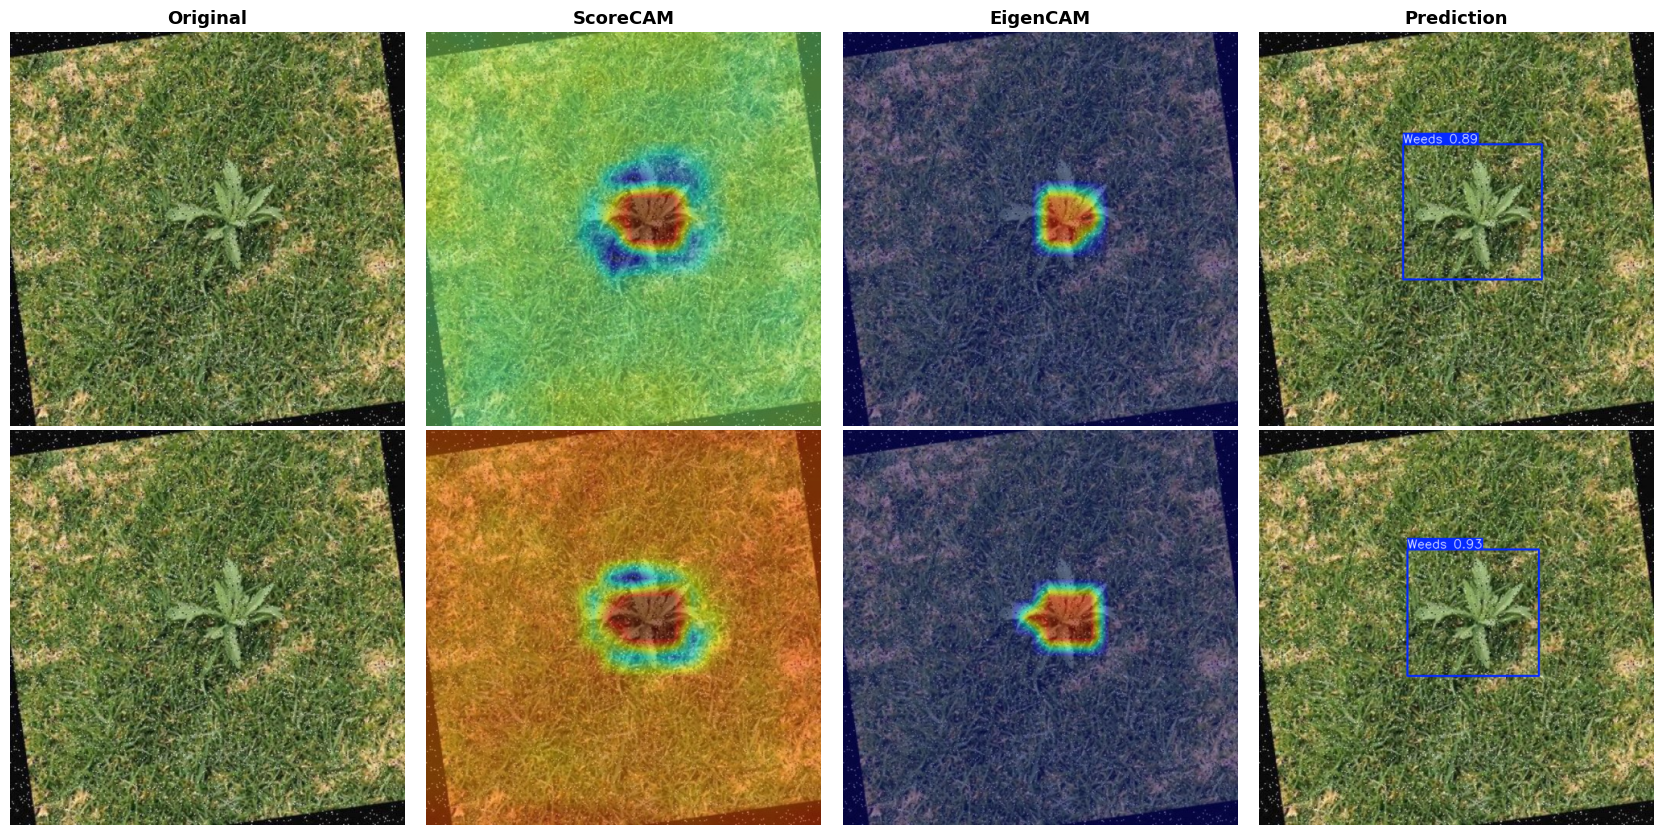

In [16]:
# ============================================================
# Run the Teacher vs Student XAI grid on one test image
# ============================================================
test_dir = Path(cfg_full["test"])
test_imgs = list_images(test_dir)
sample_img = Path(random.choice(test_imgs))
print("Sample image:", sample_img.name)

MODEL_ZOO = {}
if Path(BEST_TEACHER).exists():
    MODEL_ZOO["🧑‍🏫 Teacher (Labeled Only)"] = BEST_TEACHER
if Path(BEST_STUDENT).exists():
    MODEL_ZOO["🎓 Student (GT + Pseudo)"] = BEST_STUDENT

if not MODEL_ZOO:
    raise FileNotFoundError("No trained weights found for Teacher/Student.")

SCORECAM_CHANNELS = 12  # increase to 24 for denser CAM maps (slower)

plot_xai_grid(
    models=MODEL_ZOO,
    img_path=sample_img,
    class_id=0,
    imgsz=IMAGE_SIZE,
    conf_pred=0.25,
    iou_pred=0.7,
    scorecam_channels=SCORECAM_CHANNELS,
)